# Automatic Differentiation
:label:`sec_autograd`

Recall from :numref:`sec_calculus`
that calculating derivatives is the crucial step
in all the optimization algorithms
that we will use to train deep networks.
While the calculations are straightforward,
working them out by hand can be tedious and error-prone,
and these issues only grow
as our models become more complex.

Fortunately all modern deep learning frameworks
take this work off our plates
by offering *automatic differentiation*
(often shortened to *autograd*).
As we pass data through each successive function,
the framework builds a *computational graph*
that tracks how each value depends on others.
To calculate derivatives,
automatic differentiation
works backwards through this graph
applying the chain rule.
The computational algorithm for applying the chain rule
in this fashion is called *backpropagation*.

While autograd libraries have become
a hot concern over the past decade,
they have a long history.
In fact the earliest references to autograd
date back over half of a century :cite:`Wengert.1964`.
The core ideas behind modern backpropagation
date to a PhD thesis from 1980 :cite:`Speelpenning.1980`
and were further developed in the late 1980s :cite:`Griewank.1989`.
While backpropagation has become the default method
for computing gradients, it is not the only option.
For instance, the Julia programming language employs
forward propagation :cite:`Revels.Lubin.Papamarkou.2016`.
Before exploring methods,
let's first master the autograd package.


In [ ]:
import torch

## A Simple Function

Let's assume that we are interested
in (**differentiating the function
$y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to the column vector $\mathbf{x}$.**)
To start, we assign `x` an initial value.


In [ ]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

[**Before we calculate the gradient
of $y$ with respect to $\mathbf{x}$,
we need a place to store it.**]
In general, we avoid allocating new memory
every time we take a derivative
because deep learning requires
successively computing derivatives
with respect to the same parameters
a great many times,
and we might risk running out of memory.
Note that the gradient of a scalar-valued function
with respect to a vector $\mathbf{x}$
is vector-valued with
the same shape as $\mathbf{x}$.


In [ ]:
# Can also create x = torch.arange(4.0, requires_grad=True)
x.requires_grad_(True)
x.grad  # The gradient is None by default

(**We now calculate our function of `x` and assign the result to `y`.**)


In [ ]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

[**We can now take the gradient of `y`
with respect to `x`**] by calling
its `backward` method.
Next, we can access the gradient
via `x`'s `grad` attribute.


In [ ]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

(**We already know that the gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to $\mathbf{x}$ should be $4\mathbf{x}$.**)
We can now verify that the automatic gradient computation
and the expected result are identical.


In [ ]:
x.grad == 4 * x

tensor([True, True, True, True])

### 1️⃣ Creating a Tensor
x = torch.arange(4.0)


torch.arange(4.0) creates a tensor: [0., 1., 2., 3.]

By default, PyTorch doesn’t track gradients for this tensor yet.

This means PyTorch won’t remember operations on x for backpropagation until you tell it to.

### 2️⃣ Enabling Gradient Tracking
x.requires_grad_(True)


This tells PyTorch: “I want to compute derivatives with respect to x.”

After this, PyTorch will remember the operations performed on x so it can calculate gradients later.

x.grad is initially None because we haven’t computed any gradient yet.

### 3️⃣ Defining a Function of x
y = 2 * torch.dot(x, x)


torch.dot(x, x) computes the dot product of x with itself:

𝑥
⋅
𝑥
=
0
∗
0
+
1
∗
1
+
2
∗
2
+
3
∗
3
=
14
x⋅x=0∗0+1∗1+2∗2+3∗3=14

Multiply by 2 → y = 28

PyTorch automatically remembers how y depends on x through a computational graph.

Notice:

y
tensor(28., grad_fn=<MulBackward0>)


grad_fn indicates PyTorch remembers the operation for backpropagation.

###4️⃣ Computing the Gradient
y.backward()


.backward() tells PyTorch: “Compute the derivative of y with respect to all tensors that have requires_grad=True.”

Here, it computes:

𝑑
𝑦
𝑑
𝑥
=
𝑑
(
2
⋅
𝑥
⋅
𝑥
)
𝑑
𝑥
=
4
𝑥
dx
dy
	​

=
dx
d(2⋅x⋅x)
	​

=4x
###5️⃣ Accessing the Gradient
x.grad


Returns the gradient of y with respect to x: [0., 4., 8., 12.]

Check:

For x = 0 → 4*0 = 0

For x = 1 → 4*1 = 4

For x = 2 → 4*2 = 8

For x = 3 → 4*3 = 12

✅ This is exactly what you would expect from the derivative formula.

###6️⃣ Why We Do This

Deep learning requires gradients to update weights.

By using .backward(), PyTorch calculates how changing each element of x changes y.

PyTorch uses memory-efficient computation so it doesn’t allocate new memory for every derivative — it reuses the same memory for gradients of large models.

###7️⃣ Summary

Create tensor → torch.arange().

Enable gradient tracking → requires_grad=True.

Define a function → y = 2 * torch.dot(x, x).

Compute gradient → y.backward().

Access gradient → x.grad

This is exactly how backpropagation works in neural networks: compute derivatives of a scalar (loss) with respect to a vector (weights) efficiently.

[**Now let's calculate
another function of `x`
and take its gradient.**]
Note that PyTorch does not automatically
reset the gradient buffer
when we record a new gradient.
Instead, the new gradient
is added to the already-stored gradient.
This behavior comes in handy
when we want to optimize the sum
of multiple objective functions.
To reset the gradient buffer,
we can call `x.grad.zero_()` as follows:


In [ ]:
x.grad.zero_()  # Reset the gradient
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## Backward for Non-Scalar Variables

When `y` is a vector,
the most natural representation
of the derivative of  `y`
with respect to a vector `x`
is a matrix called the *Jacobian*
that contains the partial derivatives
of each component of `y`
with respect to each component of `x`.
Likewise, for higher-order `y` and `x`,
the result of differentiation could be an even higher-order tensor.

While Jacobians do show up in some
advanced machine learning techniques,
more commonly we want to sum up
the gradients of each component of `y`
with respect to the full vector `x`,
yielding a vector of the same shape as `x`.
For example, we often have a vector
representing the value of our loss function
calculated separately for each example among
a *batch* of training examples.
Here, we just want to (**sum up the gradients
computed individually for each example**).


Because deep learning frameworks vary
in how they interpret gradients of
non-scalar tensors,
PyTorch takes some steps to avoid confusion.
Invoking `backward` on a non-scalar elicits an error
unless we tell PyTorch how to reduce the object to a scalar.
More formally, we need to provide some vector $\mathbf{v}$
such that `backward` will compute
$\mathbf{v}^\top \partial_{\mathbf{x}} \mathbf{y}$
rather than $\partial_{\mathbf{x}} \mathbf{y}$.
This next part may be confusing,
but for reasons that will become clear later,
this argument (representing $\mathbf{v}$) is named `gradient`.
For a more detailed description, see Yang Zhang's
[Medium post](https://zhang-yang.medium.com/the-gradient-argument-in-pytorchs-backward-function-explained-by-examples-68f266950c29).


In [ ]:
x.grad.zero_()
y = x * x
y.backward(gradient=torch.ones(len(y)))  # Faster: y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

Absolutely! Let’s go through a practical example so you can see why PyTorch treats gradients this way for vectors, and how it’s used in real deep learning.

### Scenario: Mini-Batch Loss in Neural Networks

**Imagine you are training a neural network for regression:**

You have 4 training examples in a batch.

Your model predicts some values x (for simplicity, let’s use a single parameter for each example).

You calculate the squared error for each example:


x = torch.tensor([0., 1., 2., 3.], requires_grad=True)  # predictions
target = torch.tensor([0., 2., 4., 6.])                # true values

y = (x - target) ** 2  # squared error for each example


Here, y is a vector: [ (0-0)^2, (1-2)^2, (2-4)^2, (3-6)^2 ] = [0, 1, 4, 9]

Each element represents the loss for a single training example.

Step 1: Summing the Loss

Neural networks optimize a scalar loss (a single number):

y_sum = y.sum()  # total loss for the batch
y_sum.backward()


Now PyTorch computes the gradient of the total loss with respect to x:
### 𝑑(𝑦0+𝑦1+𝑦2+𝑦3)𝑑𝑥𝑖=2(𝑥𝑖−𝑡𝑎𝑟𝑔𝑒𝑡𝑖)dxi
	​
### d(y0+y1+y2+y3)=2(xi−targeti)

So for our example:

x.grad = [ 2*(0-0), 2*(1-2), 2*(2-4), 2*(3-6) ]
       = [ 0, -2, -4, -6 ]


✅ This gradient tells you how to change each prediction to reduce the total batch loss.

Step 2: Using the gradient Argument

Instead of summing manually, PyTorch allows:

y.backward(gradient=torch.ones(len(y)))


This is equivalent to summing: it tells PyTorch to sum up the contributions of each element to get a single gradient vector.

x.grad will be exactly [0, -2, -4, -6].

Step 3: Why This Matters in Practice

In deep learning, you almost never compute loss for one example at a time; you use mini-batches.

The loss for each example is a vector.

PyTorch needs a way to reduce this vector to a scalar before calculating the gradient of the parameters.

The gradient vector you get (x.grad) is exactly what you use to update model parameters using gradient descent.

Step 4: Visual Intuition
Example	Prediction x	Target	Loss (x-target)^2	Gradient 2*(x-target)
0	0	0	0	0
1	1	2	1	-2
2	2	4	4	-4
3	3	6	9	-6

Gradient vector [0, -2, -4, -6] → tells the model how to adjust predictions to reduce the batch loss.

✅ Key Takeaways

Vector outputs (like batch losses) need to be reduced to a sc

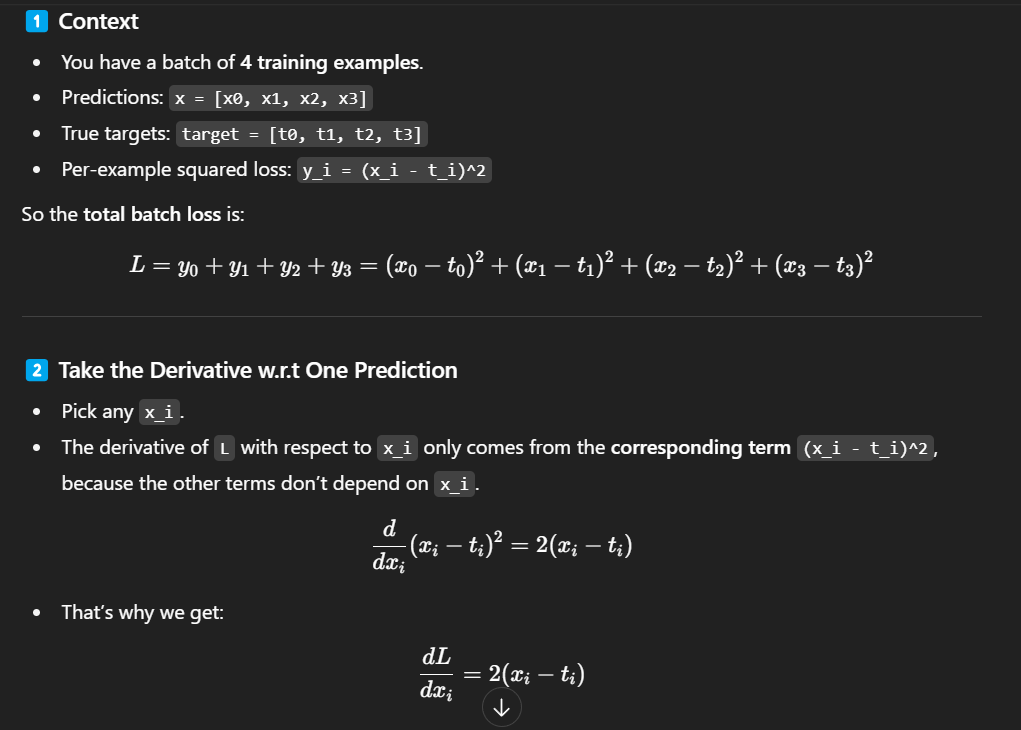

## Detaching Computation

Sometimes, we wish to [**move some calculations
outside of the recorded computational graph.**]
For example, say that we use the input
to create some auxiliary intermediate terms
for which we do not want to compute a gradient.
In this case, we need to *detach*
the respective computational graph
from the final result.
The following toy example makes this clearer:
suppose we have `z = x * y` and `y = x * x`
but we want to focus on the *direct* influence of `x` on `z`
rather than the influence conveyed via `y`.
In this case, we can create a new variable `u`
that takes the same value as `y`
but whose *provenance* (how it was created)
has been wiped out.
Thus `u` has no ancestors in the graph
and gradients do not flow through `u` to `x`.
For example, taking the gradient of `z = x * u`
will yield the result `u`,
(not `3 * x * x` as you might have
expected since `z = x * x * x`).


In [ ]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

Note that while this procedure
detaches `y`'s ancestors
from the graph leading to `z`,
the computational graph leading to `y`
persists and thus we can calculate
the gradient of `y` with respect to `x`.


In [ ]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Gradients and Python Control Flow

So far we reviewed cases where the path from input to output
was well defined via a function such as `z = x * x * x`.
Programming offers us a lot more freedom in how we compute results.
For instance, we can make them depend on auxiliary variables
or condition choices on intermediate results.
One benefit of using automatic differentiation
is that [**even if**] building the computational graph of
(**a function required passing through a maze of Python control flow**)
(e.g., conditionals, loops, and arbitrary function calls),
(**we can still calculate the gradient of the resulting variable.**)
To illustrate this, consider the following code snippet where
the number of iterations of the `while` loop
and the evaluation of the `if` statement
both depend on the value of the input `a`.


In [ ]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

Below, we call this function, passing in a random value, as input.
Since the input is a random variable,
we do not know what form
the computational graph will take.
However, whenever we execute `f(a)`
on a specific input, we realize
a specific computational graph
and can subsequently run `backward`.


In [ ]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

Even though our function `f` is, for demonstration purposes, a bit contrived,
its dependence on the input is quite simple:
it is a *linear* function of `a`
with piecewise defined scale.
As such, `f(a) / a` is a vector of constant entries
and, moreover, `f(a) / a` needs to match
the gradient of `f(a)` with respect to `a`.


In [ ]:
a.grad == d / a

tensor(True)

Dynamic control flow is very common in deep learning.
For instance, when processing text, the computational graph
depends on the length of the input.
In these cases, automatic differentiation
becomes vital for statistical modeling
since it is impossible to compute the gradient *a priori*.

## Discussion

You have now gotten a taste of the power of automatic differentiation.
The development of libraries for calculating derivatives
both automatically and efficiently
has been a massive productivity booster
for deep learning practitioners,
liberating them so they can focus on less menial.
Moreover, autograd lets us design massive models
for which pen and paper gradient computations
would be prohibitively time consuming.
Interestingly, while we use autograd to *optimize* models
(in a statistical sense)
the *optimization* of autograd libraries themselves
(in a computational sense)
is a rich subject
of vital interest to framework designers.
Here, tools from compilers and graph manipulation
are leveraged to compute results
in the most expedient and memory-efficient manner.

For now, try to remember these basics: (i) attach gradients to those variables with respect to which we desire derivatives; (ii) record the computation of the target value; (iii) execute the backpropagation function; and  (iv) access the resulting gradient.


## Exercises

1. Why is the second derivative much more expensive to compute than the first derivative?
1. After running the function for backpropagation, immediately run it again and see what happens. Investigate.
1. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or a matrix? At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?
1. Let $f(x) = \sin(x)$. Plot the graph of $f$ and of its derivative $f'$. Do not exploit the fact that $f'(x) = \cos(x)$ but rather use automatic differentiation to get the result.
1. Let $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$. Write out a dependency graph tracing results from $x$ to $f(x)$.
1. Use the chain rule to compute the derivative $\frac{df}{dx}$ of the aforementioned function, placing each term on the dependency graph that you constructed previously.
1. Given the graph and the intermediate derivative results, you have a number of options when computing the gradient. Evaluate the result once starting from $x$ to $f$ and once from $f$ tracing back to $x$. The path from $x$ to $f$ is commonly known as *forward differentiation*, whereas the path from $f$ to $x$ is known as backward differentiation.
1. When might you want to use forward, and when backward, differentiation? Hint: consider the amount of intermediate data needed, the ability to parallelize steps, and the size of matrices and vectors involved.


[Discussions](https://discuss.d2l.ai/t/35)


# Task
Address all questions in the user's prompt regarding automatic differentiation, including explanations, code examples, and comparisons of forward and backward differentiation.

## Explain the cost difference between first and second derivatives

### Subtask:
Address the first exercise about the computational cost of second derivatives.


**Reasoning**:
The subtask is to explain why computing the second derivative is more expensive than the first derivative. This can be addressed by providing a markdown explanation covering the points outlined in the instructions.



In [1]:
# The first exercise asks why the second derivative is much more expensive to compute than the first derivative.

# Explanation:
# Computing the second derivative involves computing the derivative of the first derivative.
# When using automatic differentiation, computing the first derivative of a function f(x) with respect to x typically involves building a computational graph of f and then performing one backward pass (backpropagation) through this graph.

# To compute the second derivative (the derivative of the first derivative), we need to differentiate the result of the first backward pass. This usually requires building a *new* computational graph that represents the operations performed during the *first* backward pass. Then, another backward pass is performed on this new graph.

# This nested differentiation process inherently increases computational complexity and memory usage.
# For a function y = f(x), where x is a vector and y is a scalar (common in machine learning loss functions), the first derivative dy/dx is a vector (the gradient).
# The second derivative, d^2y/dx^2, is a matrix called the Hessian matrix.
# Computing the gradient involves one backward pass.
# Computing the Hessian (or products involving the Hessian) typically requires additional backward passes or more complex graph traversals.
# Specifically, computing the full Hessian matrix for a function with respect to a vector of size N can be roughly N times more expensive than computing the gradient, as it might involve N gradient computations.
# For high-dimensional input vectors (common in deep learning models with millions of parameters), computing the full Hessian is often computationally prohibitive due to its size (N x N) and the cost of calculating all its entries.

## Investigate running backward twice

### Subtask:
Explain and demonstrate what happens when `backward()` is called multiple times without resetting the gradient.


**Reasoning**:
Follow the instructions to demonstrate the effect of calling `backward()` multiple times without resetting the gradient, by calculating y, calling backward twice, and printing the gradient after each call.



In [4]:
import torch

# Redefine x and enable gradient tracking
x = torch.arange(4.0, requires_grad=True)
print("Initial x:", x)

# Reset the gradient to zero (should be None or zero initially, but good practice)
if x.grad is not None:
    x.grad.zero_()
print("Gradient after initial definition and zero_():", x.grad)

# Calculate y = x * x
y = x * x
print("\ny =", y)

# Call backward() the first time, retaining the graph
print("\nCalculating gradient for the first time (retaining graph)...")
y.sum().backward(retain_graph=True)

# Print the gradient after the first backward pass
print("Gradient after first backward():", x.grad)

# Call backward() again WITHOUT resetting the gradient
print("\nCalculating gradient for the second time (without zeroing)...")
y.sum().backward()

# Print the gradient after the second backward pass
print("Gradient after second backward():", x.grad)

Initial x: tensor([0., 1., 2., 3.], requires_grad=True)
Gradient after initial definition and zero_(): None

y = tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)

Calculating gradient for the first time (retaining graph)...
Gradient after first backward(): tensor([0., 2., 4., 6.])

Calculating gradient for the second time (without zeroing)...
Gradient after second backward(): tensor([ 0.,  4.,  8., 12.])


**Reasoning**:
The demonstration code has successfully run and shown the gradient accumulation. The next step is to provide the required markdown explanation as specified in the instructions.



## Analyze control flow with non-scalar inputs

### Subtask:
Explain how the control flow example behaves with vector or matrix inputs and how to handle non-scalar outputs.


## When to use forward vs. backward differentiation

The choice between forward and backward differentiation often depends on the shapes of the input and output tensors of the function you are differentiating. Consider a function $f: \mathbb{R}^n \to \mathbb{R}^m$ that maps an $n$-dimensional input vector to an $m$-dimensional output vector. The Jacobian matrix of this function has dimensions $m \times n$.

**Forward Differentiation:**

-   In forward mode, you compute $\frac{\partial f_j}{\partial x_i}$ by propagating derivatives forward.
-   To compute the full Jacobian, you need to perform $n$ forward passes. Each pass computes a column of the Jacobian (the derivative of the entire output vector with respect to one element of the input vector).
-   The cost of a single forward pass for differentiation is roughly proportional to the cost of computing the function itself.
-   **Use cases:** Forward mode is generally more efficient when the number of outputs ($m$) is much larger than the number of inputs ($n$). This is because you need $n$ forward passes, and each pass computes gradients for all $m$ outputs with respect to one input. If $n \ll m$, this can be faster than backward mode. It's also useful for computing directional derivatives easily.

**Backward Differentiation:**

-   In backward mode (backpropagation), you compute $\frac{\partial f_j}{\partial x_i}$ by propagating derivatives backward from the output.
-   To compute the full Jacobian, you need to perform $m$ backward passes. Each pass computes a row of the Jacobian (the derivative of one element of the output vector with respect to the entire input vector).
-   The cost of a single backward pass is roughly proportional to the cost of computing the function itself.
-   **Use cases:** Backward mode is generally much more efficient when the number of outputs ($m$) is much smaller than the number of inputs ($n$). This is the typical scenario in deep learning, where you have a scalar loss function ($m=1$) and millions of parameters ($n$ is very large). In this case, you only need one backward pass to compute the gradient of the loss with respect to all parameters. This is why backpropagation is the dominant algorithm for training neural networks.

**Considering the Hints:**

-   **Amount of intermediate data needed:** Both methods need to store intermediate values for the computation graph, but the memory requirements can differ. Backward mode typically requires storing all intermediate activations to compute gradients, which can be significant. Forward mode's memory usage is often related to the depth of the graph.
-   **Ability to parallelize steps:** Both can be parallelized, but in different ways. Operations within a single forward or backward pass can be parallelized.
-   **Size of matrices and vectors involved:** As discussed, the relative sizes of the input and output vectors ($n$ and $m$) are the primary factor determining the efficiency of forward versus backward differentiation for computing the full Jacobian.

**Summary:**

-   If $n \ll m$ (many outputs, few inputs), **forward mode** is likely more efficient.
-   If $m \ll n$ (few outputs, many inputs), **backward mode** is likely more efficient (this is the common case in deep learning).
-   If $n \approx m$, the efficiency is roughly comparable, and other factors might influence the choice.

For computing the gradient of a scalar loss with respect to many parameters (the core of neural network training), backward differentiation (backpropagation) is overwhelmingly preferred due to its efficiency ($m=1$).

## Compare forward and backward differentiation

Given the dependency graph for $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$, we can evaluate the derivative $\frac{df}{dx}$ using two main approaches: forward differentiation and backward differentiation.

**Forward Differentiation:**

Forward differentiation (also known as forward mode automatic differentiation) proceeds from the inputs to the outputs. You compute the derivative of each intermediate variable with respect to the input variable ($x$) as you move forward through the computational graph.

For our function, starting from $x$, we would compute:

1.  $\frac{dx_{squared}}{dx} = \frac{d}{dx}(x^2) = 2x$
2.  $\frac{d log_{x_{squared}}}{dx} = \frac{d}{dx}(\log(x^2))$ (using the chain rule based on $\frac{d log_{x_{squared}}}{dx_{squared}}$ and $\frac{dx_{squared}}{dx}$)
    $\frac{d log_{x_{squared}}}{dx} = \frac{1}{x^2} \cdot 2x = \frac{2}{x}$
3.  $\frac{d sin_x}{dx} = \frac{d}{dx}(\sin(x)) = \cos(x)$
4.  $\frac{d product}{dx} = \frac{d}{dx}(log_{x_{squared}} \cdot sin_x)$ (using the product rule based on $\frac{d log_{x_{squared}}}{dx}$, $log_{x_{squared}}$, $\frac{d sin_x}{dx}$, and $sin_x$)
    $\frac{d product}{dx} = \frac{d log_{x_{squared}}}{dx} \cdot sin_x + log_{x_{squared}} \cdot \frac{d sin_x}{dx} = \frac{2}{x} \cdot \sin(x) + \log(x^2) \cdot \cos(x)$
5.  $\frac{dx_{inv}}{dx} = \frac{d}{dx}(x^{-1}) = -\frac{1}{x^2}$
6.  $\frac{df}{dx} = \frac{d}{dx}(product + x_{inv})$ (using the sum rule based on $\frac{d product}{dx}$ and $\frac{dx_{inv}}{dx}$)
    $\frac{df}{dx} = \frac{d product}{dx} + \frac{dx_{inv}}{dx} = \left(\frac{2\sin(x)}{x} + \log(x^2) \cdot \cos(x)\right) - \frac{1}{x^2}$

**Backward Differentiation:**

Backward differentiation (also known as reverse mode automatic differentiation or backpropagation) proceeds from the outputs to the inputs. You start with the derivative of the output with respect to itself ($\frac{df}{df} = 1$) and then compute the derivative of the output with respect to each intermediate variable as you move backward through the computational graph, using the chain rule.

For our function, starting from $f(x)$, we want to compute $\frac{df}{dx}$:

1.  $\frac{df}{df} = 1$
2.  Moving backward from $f$ to $product$ and $x_{inv}$:
    $\frac{df}{d product} = 1$ (from $f = product + x_{inv}$)
    $\frac{df}{d x_{inv}} = 1$ (from $f = product + x_{inv}$)
3.  Moving backward from $product$ to $log_{x_{squared}}$ and $sin_x$:
    $\frac{df}{d log_{x_{squared}}} = \frac{df}{d product} \cdot \frac{d product}{d log_{x_{squared}}} = 1 \cdot \sin(x) = \sin(x)$ (using the chain rule)
    $\frac{df}{d sin_x} = \frac{df}{d product} \cdot \frac{d product}{d sin_x} = 1 \cdot \log(x^2) = \log(x^2)$ (using the chain rule)
4.  Moving backward from $log_{x_{squared}}$ to $x_{squared}$:
    $\frac{df}{d x_{squared}} = \frac{df}{d log_{x_{squared}}} \cdot \frac{d log_{x_{squared}}}{d x_{squared}} = \sin(x) \cdot \frac{1}{x_{squared}} = \sin(x) \cdot \frac{1}{x^2}$ (using the chain rule)
5.  Moving backward from $x_{squared}$ and $sin_x$ and $x_{inv}$ to $x$:
    To get $\frac{df}{dx}$, we sum the contributions from all paths leading from $f$ back to $x$. The paths are:
    -   $f \leftarrow product \leftarrow log_{x_{squared}} \leftarrow x_{squared} \leftarrow x$
    -   $f \leftarrow product \leftarrow sin_x \leftarrow x$
    -   $f \leftarrow x_{inv} \leftarrow x$

    -   Contribution from $f \leftarrow x_{inv} \leftarrow x$:
        $\frac{df}{dx} = \frac{df}{d x_{inv}} \cdot \frac{d x_{inv}}{dx} = 1 \cdot (-\frac{1}{x^2}) = -\frac{1}{x^2}$
    -   Contribution from $f \leftarrow product \leftarrow log_{x_{squared}} \leftarrow x_{squared} \leftarrow x$:
        $\frac{df}{dx} = \frac{df}{d log_{x_{squared}}} \cdot \frac{d log_{x_{squared}}}{d x_{squared}} \cdot \frac{d x_{squared}}{dx} = \sin(x) \cdot \frac{1}{x^2} \cdot 2x = \frac{2\sin(x)}{x}$
    -   Contribution from $f \leftarrow product \leftarrow sin_x \leftarrow x$:
        $\frac{df}{dx} = \frac{df}{d sin_x} \cdot \frac{d sin_x}{dx} = \log(x^2) \cdot \cos(x)$

    Summing these contributions:
    $\frac{df}{dx} = -\frac{1}{x^2} + \frac{2\sin(x)}{x} + \log(x^2) \cdot \cos(x)$

**Comparison:**

Both forward and backward differentiation yield the same correct derivative. The key difference lies in how they traverse the graph and compute the derivatives.

-   **Forward mode** computes $\frac{\partial \text{output}}{\partial \text{input}_i}$ for each input $i$ by propagating derivatives forward.
-   **Backward mode** computes $\frac{\partial \text{output}_j}{\partial \text{input}}$ for each output $j$ by propagating derivatives backward.

This difference in approach leads to different computational costs depending on the shape of the input and output. We will discuss this in the next section.

## Compute derivative using the chain rule

Let's use the chain rule to compute the derivative $\frac{df}{dx}$ for the function $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$. We'll use the intermediate variables defined in the dependency graph description:

- $x_{squared} = x^2$
- $log_{x_{squared}} = \log(x_{squared}) = \log(x^2)$
- $sin_x = \sin(x)$
- $product = log_{x_{squared}} \cdot sin_x$
- $x_{inv} = x^{-1}$
- $f(x) = product + x_{inv}$

We can break down the derivative using the sum rule:
$\frac{df}{dx} = \frac{d}{dx}(product + x_{inv}) = \frac{d}{dx}(product) + \frac{d}{dx}(x_{inv})$

Let's compute each term separately:

**Term 1: $\frac{d}{dx}(x_{inv}) = \frac{d}{dx}(x^{-1})$**
This is a basic power rule:
$\frac{d}{dx}(x^{-1}) = -1 \cdot x^{-2} = -\frac{1}{x^2}$

**Term 2: $\frac{d}{dx}(product) = \frac{d}{dx}(log_{x_{squared}} \cdot sin_x)$**
We use the product rule: $\frac{d}{dx}(uv) = u\frac{dv}{dx} + v\frac{du}{dx}$, where $u = log_{x_{squared}}$ and $v = sin_x$.

First, find $\frac{d}{dx}(sin_x)$:
$\frac{d}{dx}(sin_x) = \frac{d}{dx}(\sin(x)) = \cos(x)$

Second, find $\frac{d}{dx}(log_{x_{squared}})$. We need the chain rule here, as $log_{x_{squared}} = \log(x^2)$:
$\frac{d}{dx}(\log(x^2))$
Let $u = x^2$. Then $\frac{du}{dx} = 2x$.
The derivative of $\log(u)$ with respect to $u$ is $\frac{1}{u}$.
Using the chain rule, $\frac{d}{dx}(\log(x^2)) = \frac{d}{du}(\log(u)) \cdot \frac{du}{dx} = \frac{1}{u} \cdot 2x = \frac{1}{x^2} \cdot 2x = \frac{2x}{x^2} = \frac{2}{x}$.

Now, apply the product rule to $\frac{d}{dx}(product)$:
$\frac{d}{dx}(product) = log_{x_{squared}} \cdot \frac{d}{dx}(sin_x) + sin_x \cdot \frac{d}{dx}(log_{x_{squared}})$
$\frac{d}{dx}(product) = \log(x^2) \cdot \cos(x) + \sin(x) \cdot \frac{2}{x}$

**Combining the terms for $\frac{df}{dx}$:**

$\frac{df}{dx} = \frac{d}{dx}(product) + \frac{d}{dx}(x_{inv})$
$\frac{df}{dx} = \left(\log(x^2) \cdot \cos(x) + \frac{2\sin(x)}{x}\right) - \frac{1}{x^2}$

**Relating to the Dependency Graph (Chain Rule Application):**

The chain rule tells us how gradients flow backward through the graph. To get $\frac{df}{dx}$, we consider all paths from $f(x)$ back to $x$.

- **Path 1: $f(x) \leftarrow x_{inv} \leftarrow x$**
  - $\frac{df}{dx_{inv}} = 1$ (from $f(x) = product + x_{inv}$)
  - $\frac{dx_{inv}}{dx} = -x^{-2} = -\frac{1}{x^2}$ (from $x_{inv} = x^{-1}$)
  - Contribution to $\frac{df}{dx}$ via this path: $\frac{df}{dx_{inv}} \cdot \frac{dx_{inv}}{dx} = 1 \cdot (-\frac{1}{x^2}) = -\frac{1}{x^2}$

- **Path 2: $f(x) \leftarrow product \leftarrow log_{x_{squared}} \leftarrow x_{squared} \leftarrow x$**
  - $\frac{df}{product} = 1$ (from $f(x) = product + x_{inv}$)
  - $\frac{d product}{d log_{x_{squared}}} = sin_x$ (from $product = log_{x_{squared}} \cdot sin_x$)
  - $\frac{d log_{x_{squared}}}{d x_{squared}} = \frac{1}{x_{squared}}$ (from $log_{x_{squared}} = \log(x_{squared})$)
  - $\frac{d x_{squared}}{d x} = 2x$ (from $x_{squared} = x^2$)
  - Contribution to $\frac{df}{dx}$ via this path: $\frac{df}{product} \cdot \frac{d product}{d log_{x_{squared}}} \cdot \frac{d log_{x_{squared}}}{d x_{squared}} \cdot \frac{d x_{squared}}{d x} = 1 \cdot sin_x \cdot \frac{1}{x_{squared}} \cdot 2x = \sin(x) \cdot \frac{1}{x^2} \cdot 2x = \frac{2\sin(x)}{x}$

- **Path 3: $f(x) \leftarrow product \leftarrow sin_x \leftarrow x$**
  - $\frac{df}{product} = 1$ (from $f(x) = product + x_{inv}$)
  - $\frac{d product}{d sin_x} = log_{x_{squared}}$ (from $product = log_{x_{squared}} \cdot sin_x$)
  - $\frac{d sin_x}{d x} = \cos(x)$ (from $sin_x = \sin(x)$)
  - Contribution to $\frac{df}{dx}$ via this path: $\frac{df}{product} \cdot \frac{d product}{d sin_x} \cdot \frac{d sin_x}{d x} = 1 \cdot log_{x_{squared}} \cdot \cos(x) = \log(x^2) \cdot \cos(x)$

Summing the contributions from all paths gives the total derivative $\frac{df}{dx}$:
$\frac{df}{dx} = -\frac{1}{x^2} + \frac{2\sin(x)}{x} + \log(x^2) \cdot \cos(x)$

This matches the result we obtained using the standard differentiation rules. The dependency graph helps visualize these paths and how the chain rule combines the local derivatives along each path.

**Reasoning**:
Explain how the function `f(a)` behaves with vector/matrix inputs, how the output `d` will be a vector/matrix, why `d.backward()` fails for non-scalar outputs, and how to handle this using `.sum()` or the `gradient` argument.



In [10]:
# Explanation: Handling vector/matrix inputs and non-scalar outputs in the control flow example

# 1. Behavior with Vector or Matrix Inputs:
# If `a` is a vector or a matrix, the function `f(a)` will still execute element-wise or using broadcasting where applicable in the operations:
# - `b = a * 2`: Element-wise multiplication. If `a` is a vector/matrix, `b` will be a vector/matrix of the same shape.
# - `while b.norm() < 1000:`: `b.norm()` calculates the Frobenius norm for a matrix or the L2 norm for a vector, resulting in a scalar. The loop continues as long as this scalar norm is less than 1000. The operations inside the loop (`b = b * 2`) continue to operate element-wise, doubling each element of `b`.
# - `if b.sum() > 0:`: `b.sum()` calculates the sum of all elements in the vector/matrix `b`, resulting in a scalar. The conditional check operates on this scalar sum.
# - `c = b` or `c = 100 * b`: Depending on the `if` condition, `c` will be assigned either the vector/matrix `b` or `100` times the vector/matrix `b` (element-wise multiplication).
# - `return c`: The function returns the vector or matrix `c`.

# 2. What the Output `d = f(a)` Would Be:
# If the input `a` is a vector or a matrix, the output `d = f(a)` will also be a tensor (vector or matrix) with the *same shape* as the input `a`. This is because all the operations within the function (multiplication, conditional assignment) preserve the shape of the intermediate tensor `b`.

# 3. Implications of Non-Scalar Output `d` and why `d.backward()` Fails:
# PyTorch's `backward()` method is designed to compute the gradient of a *scalar* output (like a loss function) with respect to the input tensors. When you call `d.backward()` on a non-scalar tensor `d` (a vector or a matrix), PyTorch raises a `RuntimeError`.
# The reason is that the gradient of a non-scalar output `d` (shape `m x n`) with respect to a non-scalar input `a` (shape `p x q`) is a higher-order tensor (specifically, it relates to the Jacobian matrix or tensor). PyTorch's `backward()` doesn't automatically compute this full Jacobian by default because:
# - It's often not what is needed in standard training (where you differentiate a scalar loss w.r.t. parameters).
# - Computing the full Jacobian can be computationally very expensive and memory-intensive for large tensors.
# PyTorch requires you to specify how to reduce the non-scalar output to a scalar before calling `backward()`.

# 4. How to Correctly Compute the Gradient of a Non-Scalar Output:
# To compute the gradient when the output `d` is non-scalar (vector or matrix), you need to reduce it to a scalar before calling `backward()`. The most common way in deep learning is to sum all the elements of the output tensor.
#
# Method 1: Summing the output
# d = f(a) # d is a vector/matrix
# total_sum = d.sum() # Reduce d to a scalar by summing
# total_sum.backward() # Compute the gradient of the sum w.r.t a
# # x.grad will now hold the gradient of the sum of elements in d w.r.t a
#
# Method 2: Using the `gradient` argument in `backward()`
# This method is mathematically equivalent to summing when the `gradient` argument is a tensor of ones with the same shape as `d`. It effectively computes the gradient of `torch.sum(d * gradient)` with respect to the input. When `gradient` is `torch.ones_like(d)`, this is the same as `d.sum().backward()`.
# d = f(a) # d is a vector/matrix
# d.backward(gradient=torch.ones_like(d)) # Compute the gradient of the sum w.r.t a
# # x.grad will hold the gradient of the sum of elements in d w.r.t a
#
# Both methods allow PyTorch's backpropagation algorithm to compute a vector/matrix gradient (of the scalar sum) with respect to the input `a`. The resulting `a.grad` will have the same shape as the input `a`.

## Plot f(x) = sin(x) and its derivative

### Subtask:
Generate code to plot the sine function and its derivative using automatic differentiation.


**Reasoning**:
Generate the code to plot the sine function and its derivative using automatic differentiation, following the instructions provided for creating tensors, calculating the function and its derivative, and plotting using matplotlib.



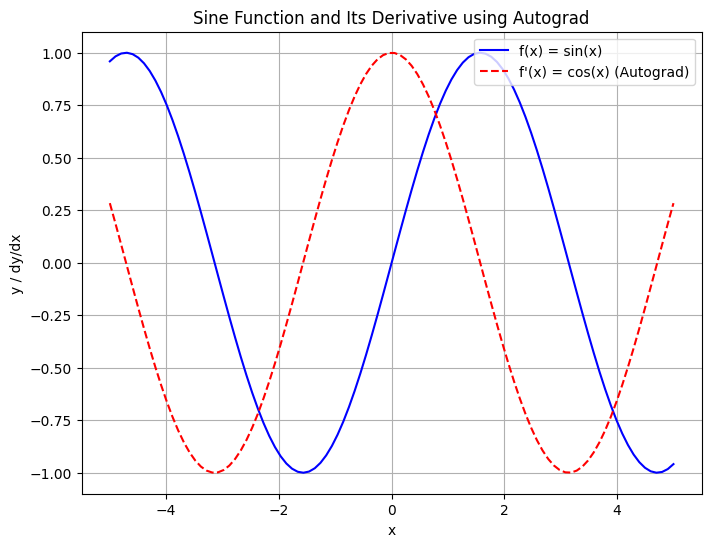

In [11]:
import torch
import matplotlib.pyplot as plt

# 2. Create a tensor x
# Use linspace for a smoother curve for plotting
x = torch.linspace(-5, 5, 100, requires_grad=True)

# 3. Calculate y = torch.sin(x)
y = torch.sin(x)

# 4. Calculate the derivative of y with respect to x
# Since y is a vector, we need to reduce it to a scalar for backward()
# We can sum the elements of y and then call backward()
y_sum = y.sum()
y_sum.backward()

# 5. Access the computed gradient from x.grad
# Detach the gradient from the computational graph and convert to NumPy array
grad_y = x.grad.detach().numpy()

# 6. Detach x and y from the computational graph and convert to NumPy arrays for plotting
x_np = x.detach().numpy()
y_np = y.detach().numpy()

# 7. Create a matplotlib figure and axes.
plt.figure(figsize=(8, 6))

# 8. Plot the original function y against x
plt.plot(x_np, y_np, label='f(x) = sin(x)', color='blue')

# 9. Plot the computed derivative x.grad against x
plt.plot(x_np, grad_y, label="f'(x) = cos(x) (Autograd)", color='red', linestyle='--')

# 10. Add a legend to the plot
plt.legend()

# 11. Add a title and labels for the x and y axes
plt.title('Sine Function and Its Derivative using Autograd')
plt.xlabel('x')
plt.ylabel('y / dy/dx')
plt.grid(True)

# 12. Display the plot
plt.show()

## Create dependency graph for f(x) = ((log x^2) * sin x) + x^-1

### Subtask:
Describe the dependency graph for the function $f(x) = ((
log x^2) \cdot \sin x) + x^{-1}$.


**Reasoning**:
I need to break down the function $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$ into elementary operations and identify the dependencies to describe the dependency graph. This involves identifying intermediate steps from the input $x$ to the final output $f(x)$.



In [12]:
# Function: f(x) = ((log x^2) * sin x) + x^-1

# Dependency Graph Description:
# Input: x

# Intermediate Calculation 1: Square of x
# Operation: Squaring
# Result: x_squared = x^2
# Dependency: x

# Intermediate Calculation 2: Logarithm of x_squared
# Operation: Natural logarithm
# Result: log_x_squared = log(x_squared) = log(x^2)
# Dependency: x_squared

# Intermediate Calculation 3: Sine of x
# Operation: Sine function
# Result: sin_x = sin(x)
# Dependency: x

# Intermediate Calculation 4: Product of log_x_squared and sin_x
# Operation: Multiplication
# Result: product = log_x_squared * sin_x
# Dependency: log_x_squared, sin_x

# Intermediate Calculation 5: Inverse of x
# Operation: Reciprocal
# Result: x_inv = x^-1
# Dependency: x

# Final Calculation: Sum of product and x_inv
# Operation: Addition
# Result: f(x) = product + x_inv
# Dependency: product, x_inv

# Dependency Graph Structure (Conceptual):
# x -> x_squared -> log_x_squared -> product
# x -> sin_x -> product
# x -> x_inv
# product -> f(x)
# x_inv -> f(x)

print("Dependency graph description for f(x) = ((log x^2) * sin x) + x^-1:")
print("\nInput: x")
print("\nIntermediate Calculations:")
print("1. x_squared = x^2 (depends on x)")
print("2. log_x_squared = log(x_squared) (depends on x_squared)")
print("3. sin_x = sin(x) (depends on x)")
print("4. product = log_x_squared * sin_x (depends on log_x_squared, sin_x)")
print("5. x_inv = x^-1 (depends on x)")
print("\nFinal Calculation:")
print("f(x) = product + x_inv (depends on product, x_inv)")

Dependency graph description for f(x) = ((log x^2) * sin x) + x^-1:

Input: x

Intermediate Calculations:
1. x_squared = x^2 (depends on x)
2. log_x_squared = log(x_squared) (depends on x_squared)
3. sin_x = sin(x) (depends on x)
4. product = log_x_squared * sin_x (depends on log_x_squared, sin_x)
5. x_inv = x^-1 (depends on x)

Final Calculation:
f(x) = product + x_inv (depends on product, x_inv)
